In [5]:
import os
import sys
script_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(script_dir, '..'))
sys.path.append(parent_dir)

from collect_data import *
from collect_metrics import *
from torch.utils.data import Dataset, DataLoader
from sklearn.linear_model import Ridge
from tqdm import tqdm
import matplotlib.pyplot as plt


In [6]:
stimuli_path = meg_path + '/stimuli/audio'
wav_files_duration = {}

for filename in os.listdir(stimuli_path):
    if filename.endswith('.wav'): 
        file_path = os.path.join(stimuli_path, filename)
        y, sr = librosa.load(file_path, sr=None)
        duration = librosa.get_duration(y=y, sr=sr)
        wav_files_duration[filename.rstrip('.wav')] = duration
print('WAVE FILES DURATION: ',wav_files_duration)
print('WAVE FILES WITH\ NUMBERS: ',task)
wav_list_without_numb = list(task.keys())


WAVE FILES DURATION:  {'lw1': 318.1481632653061, 'lw1_3': 53.072426303854876, 'lw1_2': 93.7512925170068, 'lw1_1': 75.44276643990929, 'lw1_0': 95.88167800453515, 'easy_money_7': 129.30312925170068, 'easy_money_6': 123.42730158730159, 'easy_money_4': 163.68920634920636, 'easy_money_5': 142.36866213151927, 'easy_money_3': 141.97519274376418, 'easy_money_0': 143.12875283446712, 'easy_money_2': 180.43360544217688, 'easy_money_1': 104.10834467120182, 'cable_spool_fort_4': 123.26390022675737, 'cable_spool_fort_5': 54.69605442176871, 'cable_spool_fort_3': 105.82820861678005, 'cable_spool_fort_2': 137.65614512471655, 'cable_spool_fort_1': 134.8726984126984, 'cable_spool_fort_0': 100.59777777777778, 'the_black_willow_9': 188.23668934240362, 'the_black_willow_8': 142.4142403628118, 'the_black_willow_7': 172.399410430839, 'the_black_willow_6': 128.21628117913832, 'the_black_willow_5': 81.94331065759637, 'the_black_willow_4': 110.45659863945578, 'the_black_willow_2': 125.23859410430839, 'the_black_

In [7]:
megsp_path = os.path.join(meg_path, 'collect_data/megsp')
megsp_list = os.listdir(megsp_path)

select_subj = "01"
megsp_list_session_0 = [f for f in megsp_list if f.startswith(select_subj) and f.split('_')[1] == '0']
megsp_list_session_1 = [f for f in megsp_list if f.startswith(select_subj) and f.split('_')[1] == '1']

meg_0_tensor_train, meg_0_tensor_valid, meg_0_tensor_test = get_splitted_tensor(megsp_list_session_0, megsp_path)
meg_1_tensor_train, meg_1_tensor_valid, meg_1_tensor_test = get_splitted_tensor(megsp_list_session_1, megsp_path)
meg_tensor_train = torch.cat((meg_0_tensor_train, meg_1_tensor_train), 0)
meg_tensor_valid = torch.cat((meg_0_tensor_valid, meg_1_tensor_valid), 0)
meg_tensor_test = torch.cat((meg_0_tensor_test, meg_1_tensor_test), 0)
print('DIMENSION_MEG_TENSOR_TRAIN: ', meg_tensor_train.shape)
print('DIMENSION_MEG_TENSOR_VALID: ', meg_tensor_valid.shape)
print('DIMENSION_MEG_TENSOR_TEST: ', meg_tensor_test.shape)

DIMENSION_MEG_TENSOR_TRAIN:  torch.Size([11958, 208, 16, 26])
DIMENSION_MEG_TENSOR_VALID:  torch.Size([1684, 208, 16, 26])
DIMENSION_MEG_TENSOR_TEST:  torch.Size([3480, 208, 16, 26])


In [4]:
audio_mfcc = torch.load(os.path.join(meg_path, 'collect_data/audio_mfcc.pt'))
audio_mel = torch.load(os.path.join(meg_path, 'collect_data/audio_mel.pt'))

In [5]:
tensor_list_train = []
tensor_list_valid = []
tensor_list_test = []
for file_tensor in audio_mel:
    train_tensor, val_tensor, test_tensor = split_tensor(file_tensor)
    tensor_list_train.append(train_tensor)
    tensor_list_valid.append(val_tensor)
    tensor_list_test.append(test_tensor)
audio_tensor_train = torch.cat(tensor_list_train, dim=0)
audio_tensor_valid = torch.cat(tensor_list_valid, dim=0)
audio_tensor_test = torch.cat(tensor_list_test, dim=0)

audio_tensor_train = torch.cat((audio_tensor_train, audio_tensor_train), 0)
audio_tensor_valid = torch.cat((audio_tensor_valid, audio_tensor_valid), 0)
audio_tensor_test = torch.cat((audio_tensor_test, audio_tensor_test), 0)
print('DIMENSION_AUDIO_TENSOR_TRAIN: ', audio_tensor_train.shape)
print('DIMENSION_AUDIO_TENSOR_VALID: ', audio_tensor_valid.shape)
print('DIMENSION_AUDIO_TENSOR_TEST: ', audio_tensor_test.shape)

DIMENSION_AUDIO_TENSOR_TRAIN:  torch.Size([11958, 128, 376])
DIMENSION_AUDIO_TENSOR_VALID:  torch.Size([1684, 128, 376])
DIMENSION_AUDIO_TENSOR_TEST:  torch.Size([3480, 128, 376])


In [6]:
pred_target = []
mse_scores = []
real_target = []
audio_train = audio_tensor_train.reshape(audio_tensor_train.shape[0], -1)
audio_test = audio_tensor_test.reshape(audio_tensor_test.shape[0], -1)

for channel in tqdm(range(num_channel)):   
    y_train = meg_tensor_train[:, channel, :, :].reshape(meg_tensor_train.shape[0], -1)
    y_test = meg_tensor_test[:, channel, :, :].reshape(meg_tensor_test.shape[0], -1)

    model = Ridge(alpha=5000, max_iter=1000)
    model.fit(audio_train, y_train)

    y_pred = model.predict(audio_test)
    mse = mean_squared_error(y_test, y_pred)
    pred_target.append(y_pred)
    real_target.append(y_test)
    mse_scores.append(mse)


100%|██████████| 208/208 [2:45:56<00:00, 47.87s/it]  


In [7]:
# save_pred_target = os.path.join(meg_path, 'collect_data/meg_prediction_ridge_mel.pt')
# torch.save(torch.tensor(pred_target), save_pred_target)
# save_mse = os.path.join(meg_path, 'collect_data/meg_mse_ridge_mel.pt')
# torch.save(torch.tensor(mse_scores), save_mse)

/tmp/ipykernel_889212/3235489375.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /croot/pytorch_1686931851744/work/torch/csrc/utils/tensor_new.cpp:245.)
  torch.save(torch.tensor(pred_target), save_pred_target)


In [8]:
real_target = []
for channel in range(num_channel):
    y_test = meg_tensor_test[:, channel, :, :].reshape(meg_tensor_test.shape[0], -1)
    real_target.append(y_test)

pred_mse_scores = torch.load(os.path.join(meg_path, 'collect_data/results_01/meg_mse_ridge_mel_01.pt'))
pred_meg_y = torch.load(os.path.join(meg_path, 'collect_data/results_01/meg_prediction_ridge_mel.pt'))
pred_meg_y = pred_meg_y.permute(1, 0, 2)
real_target = torch.tensor(np.array(real_target))
real_target = real_target.permute(1, 0, 2)
print("PREDICTION_SHAPE:", pred_meg_y.shape)

PREDICTION_SHAPE: torch.Size([3480, 208, 416])


In [9]:
pred_meg_y = pred_meg_y.reshape(-1, num_channel, 16, 26)
real_target = real_target.reshape(-1, num_channel, 16, 26)
print(pred_meg_y.shape)
print(real_target.shape)

torch.Size([3480, 208, 16, 26])
torch.Size([3480, 208, 16, 26])


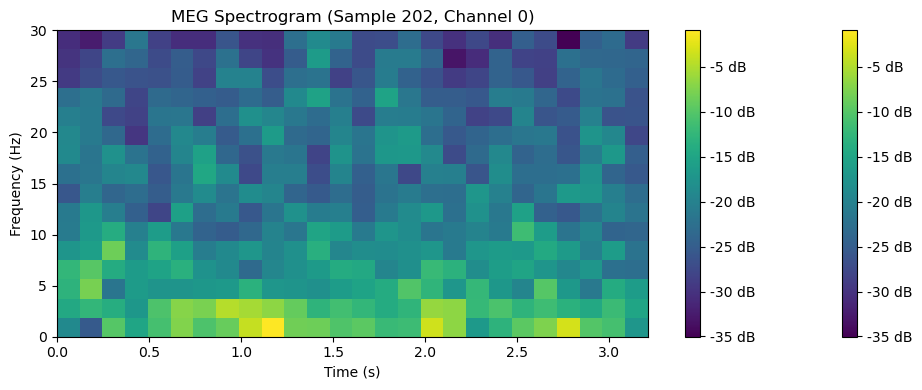

In [6]:
plot_spectrogram(pred_meg_y, sampling_meg, 202, 0)

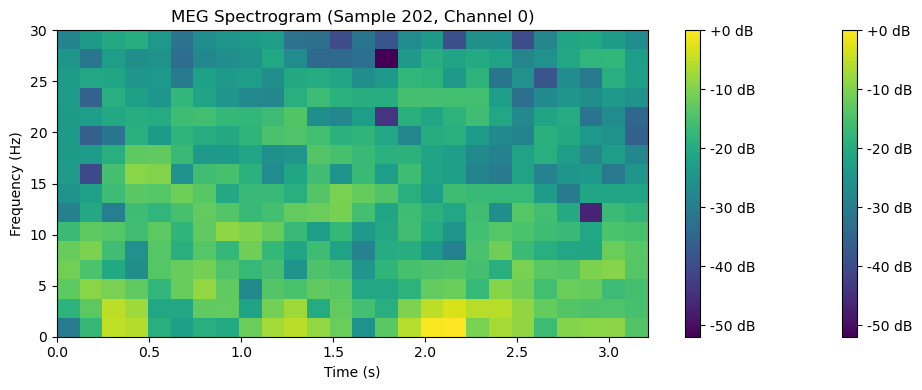

In [7]:
plot_spectrogram(real_target, sampling_meg, 202, 0)

In [11]:
# FREQUENCY BANDS METRICS

metrics_by_band = bands_metrics(real_target, pred_meg_y, freq_bands)

for band_name, metrics_list in tqdm(metrics_by_band.items()):
    print(f'Metrics for {band_name} band:')
    for metrics in metrics_list:
        print(f"Channel {metrics['channel']}: Pearson Corr {metrics['pearson_corr']:.4f}, Mod_R^2 {metrics['modified_r2']:.4f}, MSE {metrics['mse']:.4f}, MAE {metrics['mae']:.4f}, MAE_Norm {metrics['mae_norm']:.4f}")




100%|██████████| 4/4 [00:00<00:00, 663.63it/s]

Metrics for delta band:
Channel 0: Pearson Corr 0.2585, Mod_R^2 0.0668, MSE 82.0364, MAE 6.7776, MAE_Norm 0.5834
Channel 1: Pearson Corr 0.2650, Mod_R^2 0.0702, MSE 82.7446, MAE 6.8113, MAE_Norm 0.5825
Channel 2: Pearson Corr 0.2522, Mod_R^2 0.0636, MSE 82.8981, MAE 6.7994, MAE_Norm 0.5818
Channel 3: Pearson Corr 0.2823, Mod_R^2 0.0797, MSE 82.3460, MAE 6.8015, MAE_Norm 0.5725
Channel 4: Pearson Corr 0.2496, Mod_R^2 0.0623, MSE 83.1811, MAE 6.8166, MAE_Norm 0.5806
Channel 5: Pearson Corr 0.2558, Mod_R^2 0.0654, MSE 83.7929, MAE 6.8216, MAE_Norm 0.5831
Channel 6: Pearson Corr 0.2869, Mod_R^2 0.0823, MSE 85.1231, MAE 6.9478, MAE_Norm 0.5708
Channel 7: Pearson Corr 0.2515, Mod_R^2 0.0633, MSE 84.1639, MAE 6.8489, MAE_Norm 0.5862
Channel 8: Pearson Corr 0.2692, Mod_R^2 0.0725, MSE 86.5292, MAE 6.9954, MAE_Norm 0.5808
Channel 9: Pearson Corr 0.2503, Mod_R^2 0.0626, MSE 83.2010, MAE 6.8176, MAE_Norm 0.5814
Channel 10: Pearson Corr 0.2392, Mod_R^2 0.0572, MSE 83.5010, MAE 6.8233, MAE_Norm 0.5

## Prova con Mfcc

In [5]:
tensor_list_train = []
tensor_list_valid = []
tensor_list_test = []
for file_tensor in audio_mfcc:
    train_tensor, val_tensor, test_tensor = split_tensor(file_tensor)
    tensor_list_train.append(train_tensor)
    tensor_list_valid.append(val_tensor)
    tensor_list_test.append(test_tensor)
audio_tensor_train = torch.cat(tensor_list_train, dim=0)
audio_tensor_valid = torch.cat(tensor_list_valid, dim=0)
audio_tensor_test = torch.cat(tensor_list_test, dim=0)

audio_tensor_train = torch.cat((audio_tensor_train, audio_tensor_train), 0)
audio_tensor_valid = torch.cat((audio_tensor_valid, audio_tensor_valid), 0)
audio_tensor_test = torch.cat((audio_tensor_test, audio_tensor_test), 0)
print('DIMENSION_AUDIO_TENSOR_TRAIN: ', audio_tensor_train.shape)
print('DIMENSION_AUDIO_TENSOR_VALID: ', audio_tensor_valid.shape)
print('DIMENSION_AUDIO_TENSOR_TEST: ', audio_tensor_test.shape)

DIMENSION_AUDIO_TENSOR_TRAIN:  torch.Size([11958, 40, 376])
DIMENSION_AUDIO_TENSOR_VALID:  torch.Size([1684, 40, 376])
DIMENSION_AUDIO_TENSOR_TEST:  torch.Size([3480, 40, 376])


In [6]:
pred_target = []
mse_scores = []
real_target = []
audio_train = audio_tensor_train.reshape(audio_tensor_train.shape[0], -1)
audio_test = audio_tensor_test.reshape(audio_tensor_test.shape[0], -1)

for channel in tqdm(range(num_channel)):   
    y_train = meg_tensor_train[:, channel, :, :].reshape(meg_tensor_train.shape[0], -1)
    y_test = meg_tensor_test[:, channel, :, :].reshape(meg_tensor_test.shape[0], -1)

    model = Ridge(alpha=5000, max_iter=1000)
    model.fit(audio_train, y_train)

    y_pred = model.predict(audio_test)
    mse = mean_squared_error(y_test, y_pred)
    pred_target.append(y_pred)
    real_target.append(y_test)
    mse_scores.append(mse)

100%|██████████| 208/208 [1:25:10<00:00, 24.57s/it]


In [7]:
# save_pred_target = os.path.join(meg_path, 'collect_data/meg_prediction_ridge_mfcc.pt')
# torch.save(torch.tensor(pred_target), save_pred_target)
# save_mse = os.path.join(meg_path, 'collect_data/meg_mse_ridge_mfcc.pt')
# torch.save(torch.tensor(mse_scores), save_mse)

/tmp/ipykernel_950264/2452017379.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /croot/pytorch_1686931851744/work/torch/csrc/utils/tensor_new.cpp:245.)
  torch.save(torch.tensor(pred_target), save_pred_target)


In [8]:
real_target = []
for channel in range(num_channel):
    y_test = meg_tensor_test[:, channel, :, :].reshape(meg_tensor_test.shape[0], -1)
    real_target.append(y_test)

pred_mse_scores = torch.load(os.path.join(meg_path, 'collect_data/meg_mse_ridge_mfcc.pt'))
pred_meg_y = torch.load(os.path.join(meg_path, 'collect_data/meg_prediction_ridge_mfcc.pt'))
pred_meg_y = pred_meg_y.permute(1, 0, 2)
real_target = torch.tensor(np.array(real_target))
real_target = real_target.permute(1, 0, 2)
print("PREDICTION_SHAPE:", pred_meg_y.shape)

PREDICTION_SHAPE: torch.Size([3480, 208, 416])


In [9]:
pred_meg_y = pred_meg_y.reshape(-1, num_channel, 16, 26)
real_target = real_target.reshape(-1, num_channel, 16, 26)
print(pred_meg_y.shape)
print(real_target.shape)

torch.Size([3480, 208, 16, 26])
torch.Size([3480, 208, 16, 26])


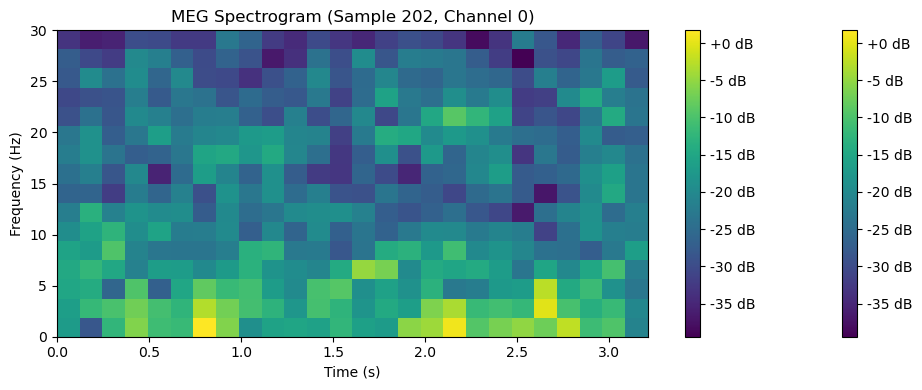

In [10]:
plot_spectrogram(pred_meg_y, sampling_meg, 202, 0)

In [12]:
# FREQUENCY BANDS METRICS

freq_bands = {
    'delta': [0, 2],
    'theta': [2, 4],
    'alpha': [4, 7],
    'beta': [7, 16],
}

metrics_by_band, corr_matrix_by_hand = bands_metrics(real_target, pred_meg_y, freq_bands)

for band_name, metrics_list in metrics_by_band.items():
    print(f'Metrics for {band_name} band:')
    for metrics in metrics_list:
        print(f"Channel {metrics['channel']}: Pearson Corr {metrics['pearson_corr']:.4f}, R^2 {metrics['r2']:.4f}, MSE {metrics['mse']:.4f}, MAE {metrics['mae']:.4f}")

delta_corr = corr_matrix_by_hand['delta'][0]['corr_matrix']


Metrics for delta band:
Channel 0: Pearson Corr 0.2575, R^2 -0.7862, MSE 103.5187, MAE 7.6866
Channel 1: Pearson Corr 0.1627, R^2 -0.7767, MSE 103.1526, MAE 7.6661
Channel 2: Pearson Corr -0.3599, R^2 -0.7375, MSE 101.8697, MAE 7.6158
Channel 3: Pearson Corr 0.2796, R^2 -0.7755, MSE 102.9685, MAE 7.6795
Channel 4: Pearson Corr 0.0006, R^2 -0.7575, MSE 103.6081, MAE 7.6857
Channel 5: Pearson Corr 0.0755, R^2 -0.7783, MSE 105.0957, MAE 7.7168
Channel 6: Pearson Corr 0.0787, R^2 -0.7667, MSE 106.5527, MAE 7.8501
Channel 7: Pearson Corr -0.0253, R^2 -0.7813, MSE 104.7552, MAE 7.7326
Channel 8: Pearson Corr 0.0270, R^2 -0.8008, MSE 108.4469, MAE 7.9239
Channel 9: Pearson Corr -0.2886, R^2 -0.7896, MSE 103.5111, MAE 7.6945
Channel 10: Pearson Corr 0.1471, R^2 -0.7867, MSE 104.8427, MAE 7.7389
Channel 11: Pearson Corr 0.6080, R^2 -0.7589, MSE 103.5366, MAE 7.6832
Channel 12: Pearson Corr 0.5824, R^2 -0.7623, MSE 102.7730, MAE 7.6444
Channel 13: Pearson Corr -0.0389, R^2 -0.7703, MSE 104.6331,